
# **DETECTING BREAST CANCER ON ULTRASOUND DATASET**





---

In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("aryashah2k/breast-ultrasound-images-dataset")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/breast-ultrasound-images-dataset


In [5]:
import shutil
import os

source = '/kaggle/input/breast-ultrasound-images-dataset'
destination = '/kaggle/working/breast-ultrasound-images-dataset'


shutil.copytree(source, destination)


'/kaggle/working/breast-ultrasound-images-dataset'

# **IMPORT MODULES**

In [6]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers,models
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Activation, BatchNormalization, Flatten, MaxPooling2D, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras import optimizers, losses
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
import os.path
from sklearn.metrics import classification_report, confusion_matrix
import itertools
import warnings
warnings.filterwarnings("ignore")

# **SET DATA PATH**

In [18]:
data = '/kaggle/working/breast-ultrasound-images-dataset'

In [12]:
from pathlib import Path
import pandas as pd
import os

# Define the directory containing images
data = '/kaggle/working/breast-ultrasound-images-dataset'  # Update this path as per your dataset location
image_dir = Path(data)

# Get file paths for both .PNG and .png files
filepaths = list(image_dir.glob('**/*.PNG')) + list(image_dir.glob('**/*.png'))

# Extract labels based on the folder names
labels = list(map(lambda x: os.path.basename(os.path.dirname(x)), filepaths))

# Create pandas Series for filepaths and labels
filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

# Combine into a DataFrame
image_df = pd.concat([filepaths, labels], axis=1)

# Display the DataFrame
print(image_df.head())


                                            Filepath   Label
0  /kaggle/working/breast-ultrasound-images-datas...  normal
1  /kaggle/working/breast-ultrasound-images-datas...  normal
2  /kaggle/working/breast-ultrasound-images-datas...  normal
3  /kaggle/working/breast-ultrasound-images-datas...  normal
4  /kaggle/working/breast-ultrasound-images-datas...  normal


In [13]:
labels

,Label
0,normal
1,normal
2,normal
3,normal
4,normal
...,...
1573,benign
1574,benign
1575,benign
1576,benign


In [14]:
filepaths

,Filepath
0,/kaggle/working/breast-ultrasound-images-datas...
1,/kaggle/working/breast-ultrasound-images-datas...
2,/kaggle/working/breast-ultrasound-images-datas...
3,/kaggle/working/breast-ultrasound-images-datas...
4,/kaggle/working/breast-ultrasound-images-datas...
...,...
1573,/kaggle/working/breast-ultrasound-images-datas...
1574,/kaggle/working/breast-ultrasound-images-datas...
1575,/kaggle/working/breast-ultrasound-images-datas...
1576,/kaggle/working/breast-ultrasound-images-datas...


# **DISPLAY FEW IMAGES { EDA }**

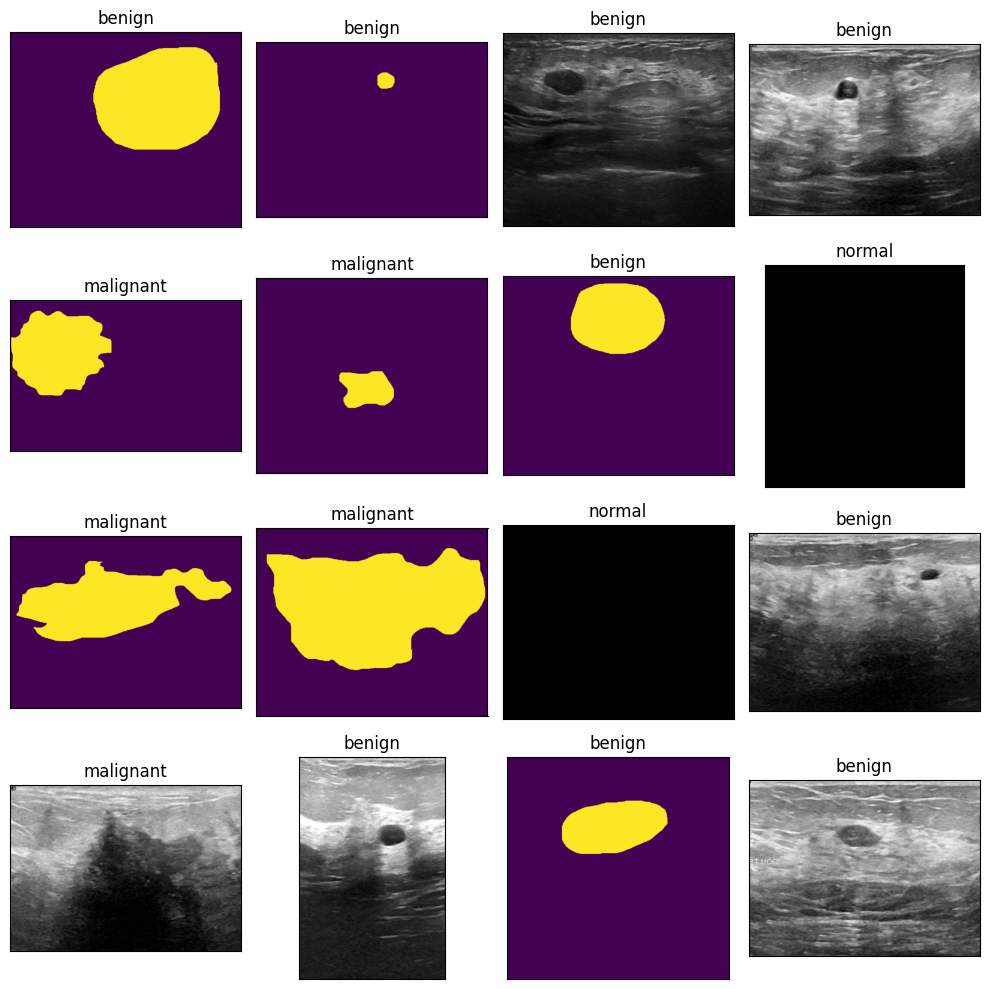

In [15]:
random_index = np.random.randint(0, len(image_df), 16)
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(10, 10),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(image_df.Filepath[random_index[i]]))
    ax.set_title(image_df.Label[random_index[i]])
plt.tight_layout()
plt.show()

# **AGUMENTATION**

In [16]:
IMAGE_SHAPE = (224, 224)

def prepare_image(file):
    img = image.load_img(file, target_size=IMAGE_SHAPE)
    img_array = image.img_to_array(img)
    return tf.keras.applications.efficientnet.preprocess_input (img_array)

# **NUMBER OF IMAGES**

In [19]:
import os
import glob

# Define the path to the dataset
data = '/kaggle/working/breast-ultrasound-images-dataset'  # Update this path to match your dataset location

# Get a list of all directories (folders) within the dataset
directories = os.listdir(data)

# Initialize lists to store file paths and corresponding labels
files = []
labels = []

# Read files from each directory
for folder in directories:
    # Use glob to find all files within each folder
    fileList = glob.glob(os.path.join(data, folder, '*'))

    # Add the folder name as a label for each file found
    labels.extend([folder] * len(fileList))
    files.extend(fileList)

# Output the total number of files and labels collected
print(len(files), len(labels))


3 3


In [20]:
selected_files = []
selected_labels = []

for file, label in zip(files, labels):
    if 'mask' not in file:
        selected_files.append(file)
        selected_labels.append(label)


len(selected_files), len(selected_labels)

(3, 3)

In [26]:
from tensorflow.keras.preprocessing import image
import numpy as np
import os
from glob import glob

# === Define data folder and classes ===
DATASET_DIR = '/kaggle/working/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT'
CLASSES = ['benign', 'malignant', 'normal']

# === Get image file paths and corresponding labels ===
files = []
labels = []

for label in CLASSES:
    folder_path = os.path.join(DATASET_DIR, label)
    for img_path in glob(os.path.join(folder_path, '*.png')):
        if '_mask' not in img_path:  # Skip mask files
            files.append(img_path)
            labels.append(label)

# === Function to prepare a single image ===
def prepare_image(file):
    try:
        img = image.load_img(file, target_size=(224, 224))  # Rescale to 224x224
        img_array = image.img_to_array(img)
        img_array /= 255.0  # Normalize to [0, 1]
        return np.expand_dims(img_array, axis=0)  # Add batch dimension
    except Exception as e:
        print(f"Error loading image {file}: {e}")
        return None

# === Load all images into memory ===
images = {
    'image': [],
    'target': []
}

for i, (file, label) in enumerate(zip(files, labels)):
    img = prepare_image(file)
    if img is not None:
        images['image'].append(img)
        images['target'].append(label)

print(f'✅ Finished loading {len(images["image"])} images.')


✅ Finished loading 780 images.


# ***LABEL THE CLASSES***

In [27]:
# convert lists to arrays
images['image'] = np.array(images['image'])
images['target'] = np.array(images['target'])

# encode the target
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

images['target'] = le.fit_transform(images['target'])

classes = le.classes_ # get the classes for each target
print(f'the target classes are: {classes}')

the target classes are: ['benign' 'malignant' 'normal']


# ***train_test_split***

In [28]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(images['image'], images['target'], test_size=.10)

x_train.shape, x_test.shape, y_train.shape, y_test.shape

((702, 1, 224, 224, 3), (78, 1, 224, 224, 3), (702,), (78,))

## **DEFINE THE MODEL HERE :**

In [38]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.applications.vgg16 import VGG16
from sklearn.model_selection import train_test_split
import numpy as np

# === Set image input shape ===
IMAGE_SHAPE = (224, 224)

# === Preprocessed data from earlier step ===
X = np.vstack(images['image'])  # shape: (n, 224, 224, 3)
y = np.array(images['target'])  # already numeric


# === Train-test split ===
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# === Load base VGG16 model ===
base_model = VGG16(
    include_top=False,
    weights='imagenet',
    input_shape=(*IMAGE_SHAPE, 3)
)
base_model.trainable = False  # freeze weights

# === Add custom top layers ===
x = base_model.output

# Conv block 1
x = layers.Conv2D(256, 3, padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)
x = layers.GlobalAveragePooling2D(keepdims=True)(x)

# Conv block 2
x = layers.Conv2D(128, 3, padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)
x = layers.GlobalAveragePooling2D(keepdims=True)(x)

# Fully connected layers
x = layers.Flatten()(x)
x = layers.Dense(64)(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)

x = layers.Dense(32)(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)
x = layers.Dropout(0.2)(x)

# Output layer
output = layers.Dense(3, activation='softmax')(x)

# Final model
model = keras.models.Model(inputs=base_model.input, outputs=output)

# === Compile the model ===
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# === Summary ===
model.summary()




Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 7, 7, 256)      │     1,179,904 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 7, 7, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_12 (Activation)      │ (None, 7, 7, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_6      │ (None, 1, 1, 256)      │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 1, 1, 128)      │       295,04

 Total params: 16,201,987 (61.81 MB)

 Trainable params: 1,486,339 (5.67 MB)

 Non-trainable params: 14,715,648 (56.14 MB)

# **RUN THE MODEL**

In [39]:
history = model.fit(
    x_train, y_train,
    validation_data=(x_test, y_test),
    batch_size=32,
    epochs=20
)

Epoch 1/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 530s 27s/step - accuracy: 0.5831 - loss: 0.9490 - val_accuracy: 0.5641 - val_loss: 1.0397
Epoch 2/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 557s 26s/step - accuracy: 0.7700 - loss: 0.5822 - val_accuracy: 0.5577 - val_loss: 0.9863
Epoch 3/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 514s 26s/step - accuracy: 0.7916 - loss: 0.5306 - val_accuracy: 0.5641 - val_loss: 0.9487
Epoch 4/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 513s 23s/step - accuracy: 0.8705 - loss: 0.4045 - val_accuracy: 0.5641 - val_loss: 0.9260
Epoch 5/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 551s 26s/step - accuracy: 0.8946 - loss: 0.3418 - val_accuracy: 0.5833 - val_loss: 0.8748
Epoch 6/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 563s 26s/step - accuracy: 0.8953 - loss: 0.2958 - val_accuracy: 0.5577 - val_loss: 0.9261
Epoch 7/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 560s 26s/step - accuracy: 0.9301 - loss: 0.2508 - val_accuracy: 0.6218 - val_loss: 0.8402
Epoch 8/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 464s 23s/step - accuracy: 0.9361 - loss: 0.2207 - val_accuracy: 0.

# **TRAINING ANALYSIS**

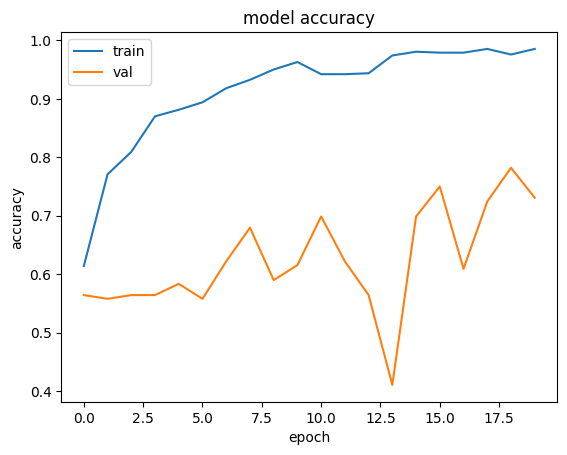

In [40]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# **PREDICT THE IMAGE BY MODEL**

In [41]:
# used to predict the model and visualize the orignal image with title of true and pred values
def predict_image(img_path, label):
    img1 = prepare_image(img_path) # preprocess the image
    res = incept_model.predict(np.expand_dims(img1, axis = 0)) # predict the image
    pred = classes[np.argmax(res)]

    # Visualize the image
    img = image.load_img(img_path)
    plt.imshow(np.array(img))
    plt.title(f'True: {label}\nPredicted: {pred}')

# **save and download the model**

In [42]:
# Saving the model
incept_model.save('breast_detect.h5')

# Downloading the model
from google.colab import files
files.download('breast_detect.h5')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>